## Residual masking

This is a notebook to test several methods to mask the residuals remaining on the difference images. They mainly due to shifts on the reprojection/registration proccess, bad photometrical calibration or PSF sampling. In the case of ATLAS, most of them have lobes with a size comparable to the PSF, so in the KBMOD search they could be associated to real objects, creating false positives.

Masking them before running KBMOD should result on a decrease of false positives and so on a better computaitonal performance.

In [1]:
import os
from kbmod.image_info import ImageInfoSet, ImageInfo
from glob import glob
from astropy.io import fits
import numpy as np
from astropy.time import Time
import kbmod.search as kb
from kbmod.run_search import run_search
#from parsers.AtlasParser import AtlasParser

This is the original ATLAS Parser where the mask is disable.

In [2]:
from datetime import datetime, timedelta
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import subprocess

import warnings
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import FITSFixedWarning

# Ignore specific warnings
warnings.simplefilter('ignore', VerifyWarning)
warnings.simplefilter('ignore', FITSFixedWarning)

class ATLASParser():
    
    def __init__(self, working_path, image_type='science', crop_params=None, align=True):
        
        # paths
        self.working_path = working_path
        if not os.path.exists(self.working_path): os.makedirs(self.working_path)
        if not os.path.exists(os.path.join(self.working_path, 'ori/')): os.makedirs(os.path.join(self.working_path, 'ori/'))
        self.ori_image_path = os.path.join(self.working_path, 'ori/')
        if not os.path.exists(os.path.join(self.working_path, 'prep_images/')): os.makedirs(os.path.join(self.working_path, 'prep_images/'))
        self.kbmod_image_path = os.path.join(self.working_path, 'prep_images/')
        if not os.path.exists(os.path.join(self.working_path, 'warped/')): os.makedirs(os.path.join(self.working_path, 'warped/'))
        self.warped_image_path = os.path.join(self.working_path, 'warped/')

        # config parameters
        self.rebinning_factor = 8
        self.image_type = image_type
        self.crop_params = crop_params


    def oversample_array(self, array):
        rows = np.repeat(array, self.rebinning_factor, axis=0)
        return np.repeat(rows, self.rebinning_factor, axis=1)      
    
    
    def correct_header(self, header, new_header):
        header['CTYPE1'] = 'RA---TAN-SIP'
        header['CTYPE2'] = 'DEC--TAN-SIP'
        header['OBS-LAT'] = header['SITELAT']
        header['OBS-LONG'] = header['SITELONG']
        header['OBS-ELEV'] = header['SITEELEV']
        if header['OBSID'][:2] == '01': header['OBSERVAT'] = 'T05'
        elif header['OBSID'][:2] == '02': header['OBSERVAT'] = 'T08'
        elif header['OBSID'][:2] == '03': header['OBSERVAT'] = 'W68'
        elif header['OBSID'][:2] == '04': header['OBSERVAT'] = 'M22'
        header['DATE-AVG'] = (datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S%z') +
                              timedelta(seconds=header['EXPTIME']/2)).strftime('%Y-%m-%dT%H:%M:%S')
        header['MJD-AVG'] = header['MJD-OBS'] + header['EXPTIME']/2/86400
        header["IDNUM"] = header['OBSID']
        header['PIXSCALE'] = header['RP_ASCL']
        header['PSF'] = header['FWHM']/2.355

        for key in list(header.keys()):
            if key.startswith('PV'): header.remove(key)

        wcs_keywords = ['CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 
                        'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'RADECSYS', 'EQUINOX', 'LONPOLE', 'LATPOLE']
        header['RADESYSa'] = header['RADECSYS']
        del header['RADECSYS']
        for keyword in wcs_keywords: header[keyword] = new_header[keyword]
        for i in range(1, header['NAXIS']+1):
            for j in range(1, header['NAXIS']+1):
                header.remove(f'PC{i}_{j}', ignore_missing=True)
                header.remove(f'CD{i}_{j}', ignore_missing=True)

        for i in range(1, header['NAXIS']+1):
            for j in range(1, 21):
                header.remove(f'PV{i}_{j}', ignore_missing=True)

        return header
    
    def get_image(self, file, ra=None, dec=None):

        # warp image
        if self.image_type == 'diff':
            ori = file.replace('fits.fz', 'diff.fz')
        else:
            ori = file
        var = file
        res_file = os.path.join(self.warped_image_path, os.path.basename(file).replace('.fits.fz', '.fits'))
        
        # warp image
        self.warp(ori, var, res_file)

        # load image
        print('Getting warped image', end="\r")
        with fits.open(res_file, output_verify='silentfix') as hdul:
            data = hdul[0].data
            new_header = hdul[0].header
        img = data[0,:,:]
        var = data[1,:,:]
        mask = self.create_mask(img)

        print('Correcting header', end="\r")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            header = fits.getheader(file, 1)
        header = self.correct_header(header, new_header)
        
        return img, header, mask, var

    def load_images(self, im_list, save=True):

        print("---------------------------------------")
        print("Loading Images")
        print("---------------------------------------")

        img_info = ImageInfoSet()
        images = []
        visit_times = []
        # del_keys = ['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'HISTORY', 'COMMENT']
        ra, dec = None, None
        t0 = datetime.utcnow()

        for i,im in enumerate(im_list):

            print(f'{i+1}/{len(im_list)}: {im}')

            sci, header, mask, var = self.get_image(im, ra, dec)
            if i == 0:
                ra, dec = header['RA'], header['DEC']

            # for key in h_wcs.keys():
            #     if key not in del_keys: header[key] = h_wcs[key]
            # header['NAXIS1'] = sci.shape[0]
            # header['NAXIS2'] = sci.shape[1]

            header_info = ImageInfo()
            header_info.populate_from_header(header)
            time_stamp = header['MJD-AVG']
            psf = kb.psf(header['PSF'])

            img = kb.layered_image(kb.raw_image(sci), 
                                    kb.raw_image(var),
                                    kb.raw_image(mask),
                                    time_stamp, psf)
            images.append(img)
            visit_times.append(time_stamp)
            img_info.append(header_info)

            print('Image added to stack', end="\r")

            if save:
                image = [fits.PrimaryHDU(sci, header), fits.PrimaryHDU(mask, header), fits.PrimaryHDU(var, header)]
                if self.image_type == 'diff': lab = [os.path.basename(im).replace('fits.fz','diff.fits')]
                else: lab = [os.path.basename(im).replace('fits.fz','sci.fits')]

                lab += [os.path.basename(im).replace('fits.fz','mask.fits'),
                        os.path.basename(im).replace('fits.fz','var.fits')]
                        
                for h in range(len(image)):
                    image[h].writeto(os.path.join(self.kbmod_image_path, lab[h]), overwrite=True, output_verify='silentfix')

        stack = kb.image_stack(images)

        # Create a list of visit times and visit times shifted to 0.0.
        img_info.set_times_mjd(np.array(visit_times))
        times = img_info.get_zero_shifted_times()
        stack.set_times(times)
        te = (datetime.utcnow() - t0).total_seconds()
        print("Stack created, time elapsed: %.1f s" % te, end="\r")

        self.stack = stack
        self.img_info = img_info
        return stack, img_info


    def warp(self, image_file, var_file, res_file):

        print('Warping image', end="\r")

        # get center coordinates
        center_ra = self.crop_params['center_coords'][0]
        center_dec = self.crop_params['center_coords'][1]
        nx = self.crop_params['crop_size']
        ny = self.crop_params['crop_size']

        # executable path
        warpsky_path = "./parsers/warpsky"
        command = [warpsky_path, image_file, res_file, '-var', var_file,'-r0', str(center_ra), '-d0', str(center_dec), '-cx', '0', '-cy', '0']
        if nx is not None:
            command += ['-nx', str(nx), '-ny', str(ny)]

        result = subprocess.run(command, capture_output=True, text=True)

    def create_mask(self, img):
        mask = np.zeros(img.shape)
        mask[img < -200] = 1
        return mask

    @staticmethod
    def crop_image(im, header, coords, size=1000):
        wcs = WCS(header)
        center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
        center_px = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        cutout = Cutout2D(im, center_px, size*u.pixel, wcs=wcs)
        cropped_data = cutout.data
        cropped_wcs = cutout.wcs
        header.update(cropped_wcs.to_header())
        return cropped_data, header
    

    @staticmethod
    def center(im, header, coords, size=1000):
        if type(coords[0]) == float:
            wcs = WCS(header)
            center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
            coords = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        return im[int(coords[0]-size/2):int(coords[0]+size/2), int(coords[1]-size/2):int(coords[1]+size/2)]


    @staticmethod
    def astrometrize(sources, im_shape, scale):
        ast = AstrometryNet()
        image_width = im_shape[0]
        image_height = im_shape[1]
        h_wcs = ast.solve_from_source_list(sources[:,0], sources[:,1],
                                            image_width, image_height,
                                            tweak_order=3, solve_timeout=180,
                                            scale_est = scale, scale_err = scale*0.1,
                                            scale_units = 'arcsecperpix')
        return h_wcs
    
    @staticmethod
    def arcsecmin_to_pxday(arcsecmin, pxsize=1.86):
        return arcsecmin/pxsize*60*24
    

    @staticmethod
    def dyn_avgstd(valuenew, nold, avgold, stdold):
        nnew = nold + (valuenew != 0).astype(np.int)
        if np.sum(nold) == 0:
            avgnew = np.asarray(valuenew, dtype=np.double)
            stdnew = np.zeros_like(valuenew, dtype=np.double)
        else:
            avgnew = avgold + (valuenew - avgold) / nnew
            stdnew = np.sqrt(
                nold/nnew * stdold**2 +
                (valuenew - avgnew) * (valuenew - avgold) / nnew
                )
        return nnew, avgnew, stdnew


In [4]:
cd ..

/app


In [20]:
results_suffix = "atlas_test"
img_typ = 'diff'
working_path = '/app/images/KBMOD/'
res_filepath = '/app/data/atlas'

size = 400#6*1024

crop_params = {'center_coords': (282.03212, -23.1228),
               'crop_size': size}

ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=crop_params)
sci_filelist = glob(os.path.join(ATLAS_Parser.ori_image_path, '*58668*.fits.fz'))
sci_filelist.sort()

stack, img_info = ATLAS_Parser.load_images(sci_filelist[:1])

---------------------------------------
Loading Images
---------------------------------------
1/1: /app/images/KBMOD/ori/01a58668o0403o.fits.fz
INFO: ting headerage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
 

In [21]:
# Load kb.raw_images into a np.array to manipulate it easily
img_array = np.zeros((stack.img_count(), size, size))
mask_array = np.zeros((stack.img_count(), size, size))
var_array = np.zeros((stack.img_count(), size, size))
for i,ima in enumerate(stack.get_images()):
    img_array[i,:] = ima.get_science()
    mask_array[i,:] = ima.get_mask()
    var_array[i,:] = ima.get_variance()

fwhm = ima.get_psf().get_stdev()*2.35


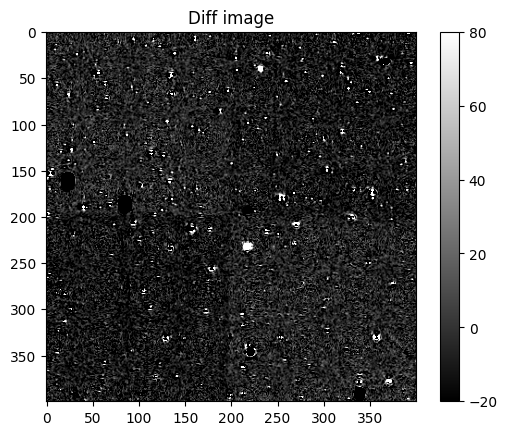

In [23]:
import matplotlib.pyplot as plt
image = img_array[0,::-1,::-1]#[0,50:-50,50:-50][::-1,::-1]
plt.imshow(image, cmap='gray', vmin=-20, vmax=80)
plt.title('Diff image')
plt.colorbar()
plt.show()


The method tested here consists on using spatial kernels for getting the std and mean over a square of size 5xFWHM. This 5 is considered to be enough for covering the dipole structure of residuals when registering error is high.
There are you thresholds:
 - std > 0.75-1.25 median std: residuals and sources
 - mean < 5-sigma sky: only residuals


In [37]:
from scipy.ndimage import generic_filter, gaussian_filter, binary_opening, binary_dilation
from datetime import datetime

image = img_array[2,::-1,::-1]

filter_size = int(2.5 * fwhm)
if filter_size % 2 == 0:
    filter_size += 1

def std_filter(values):
    return np.std(values)

def mean_filter(values):
    return np.mean(values)

time = datetime.now()
std_dev_image = generic_filter(image, std_filter, size=filter_size)
print('std_dev_image', datetime.now() - time)
time = datetime.now()
mean_image = generic_filter(image, mean_filter, size=filter_size)
print('mean_image', datetime.now() - time)

time = datetime.now()
sky_std_med = np.median(std_dev_image)
print('sky_std_med', datetime.now() - time)
sky_std_std = np.std(std_dev_image[(std_dev_image < sky_std_med*1.25) & (std_dev_image > sky_std_med*0.75)])
print('sky_std_std', datetime.now() - time)

time = datetime.now()
mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e4)
print('mask', datetime.now() - time)

time = datetime.now()
sky_med = np.median(mean_image[mask==0])
sky_std = np.std(mean_image[mask==0])
print('sky_med', datetime.now() - time)

mask = (mean_image < sky_med + 5*sky_std) & mask

time = datetime.now()
mask = (mask * 255).astype(np.uint8)
mask = gaussian_filter(mask, sigma=1) > 127
mask = binary_opening(mask, structure=np.ones((3, 3)))
mask = binary_dilation(mask, structure=np.ones((3, 3)))
print('dilate_mask', datetime.now() - time)



fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(std_dev_image, cmap='gray', vmin=-10, vmax=40)
ax[0].set_title('std kernel')
ax[1].imshow(mean_image, cmap='gray', vmin=-10, vmax=40)
ax[1].set_title('mean kernel')
ax[2].imshow(mask, cmap='gray', vmin=0,vmax=1)
ax[2].set_title('mask')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 1

NameError: name 'mask' is not defined

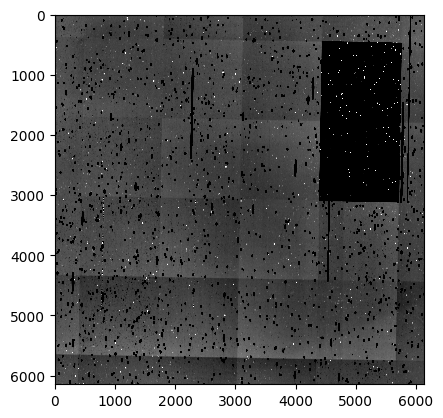

In [8]:
import matplotlib.colors as co
c_white = co.colorConverter.to_rgba('white',alpha = 0)
c_black= co.colorConverter.to_rgba('red',alpha = 0.6)
cmap_rb = co.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)
            
plt.imshow(image, cmap='gray', vmin=-40, vmax=100)
plt.imshow(mask, cmap=cmap_rb, alpha=0.5, vmin=0, vmax=1)
plt.title('Masked image')


-- --
OPENCV IMPLEMENTATION

In [9]:
# !pip install cupy-cuda12x -y
# !pip install opencv-python
import cupy as cp
from cupyx.scipy.ndimage import convolve
import gc
import cv2



Total time: 0:00:00.006802


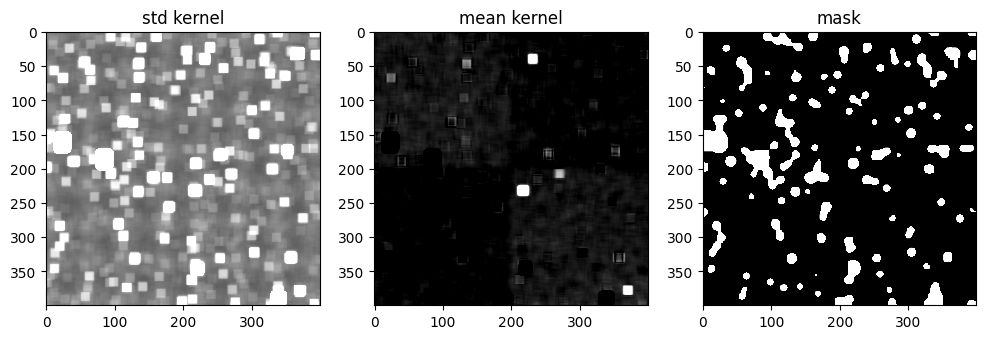

In [24]:


t0 = datetime.now()

filter_size = int(5 * fwhm)
if filter_size % 2 == 0:
    filter_size += 1


mean_image = cv2.boxFilter(image, -1, (filter_size, filter_size))
squared_img = cv2.boxFilter(image**2, -1, (filter_size, filter_size))
std_dev_image = np.sqrt(squared_img - mean_image**2)



sky_std_med = np.median(std_dev_image)

mask_for_std = (std_dev_image < sky_std_med*1.25) & (std_dev_image > sky_std_med*0.75)
sky_std_std = np.std(std_dev_image[mask_for_std])



mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e3)

sky_med = np.median(mean_image[~mask])
sky_std = np.std(mean_image[~mask])


mask = (mean_image < sky_med + 5*sky_std) & mask

time = datetime.now()
mask = (mask.astype(np.uint8) * 255) 
mask_blurred = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3)
mask = np.where(mask_blurred > 127, 255, 0).astype(np.uint8)
#kernel = np.ones((3, 3), np.uint8)
mask = cv2.erode(mask, np.ones((5, 5), np.uint8))


print('\nTotal time:', datetime.now() - t0)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(std_dev_image, cmap='gray', vmin=-10, vmax=40)
ax[0].set_title('std kernel')
ax[1].imshow(mean_image, cmap='gray', vmin=-10, vmax=40)
ax[1].set_title('mean kernel')
ax[2].imshow(mask, cmap='gray', vmin=0,vmax=1)
ax[2].set_title('mask')
plt.show()


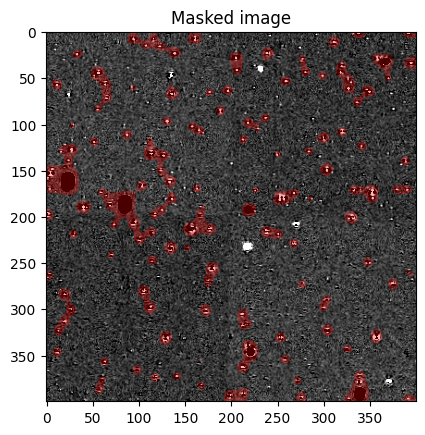

In [25]:
import matplotlib.colors as co
c_white = co.colorConverter.to_rgba('white',alpha = 0)
c_black= co.colorConverter.to_rgba('red',alpha = 0.6)
cmap_rb = co.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)
            
plt.imshow(image, cmap='gray', vmin=-40, vmax=100),
plt.imshow(mask, cmap=cmap_rb, alpha=0.5, vmin=0, vmax=1)
plt.title('Masked image')
plt.show()

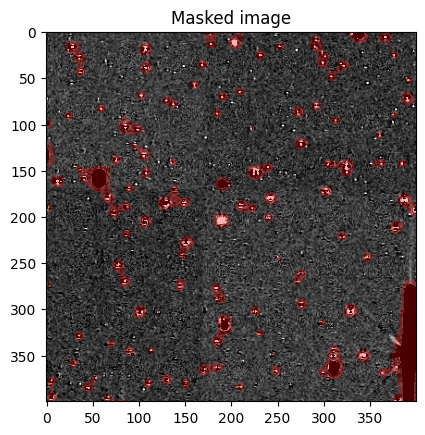

In [12]:
import matplotlib.colors as co
c_white = co.colorConverter.to_rgba('white',alpha = 0)
c_black= co.colorConverter.to_rgba('red',alpha = 0.6)
cmap_rb = co.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)
            
plt.imshow(image, cmap='gray', vmin=-40, vmax=100),
plt.imshow(mask, cmap=cmap_rb, alpha=0.5, vmin=0, vmax=1)
plt.title('Masked image')
plt.show()

-- --
## PCA over stamps
-- --

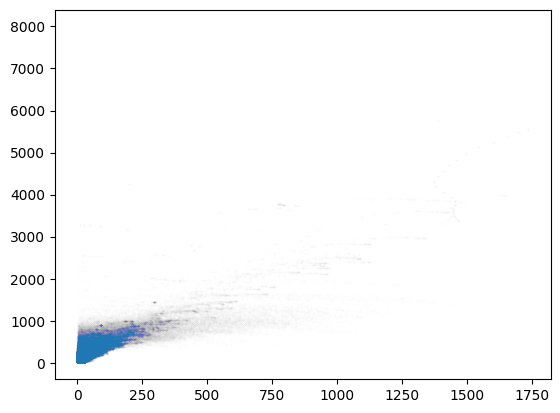

In [19]:
mask = mean_image.flatten() > 0
plt.scatter(mean_image.flatten()[mask], std_dev_image.flatten()[mask], s=0.1, alpha=0.01)

(array([1.0648000e+04, 3.3660000e+03, 2.8210000e+03, 2.6470000e+03,
        2.6350000e+03, 2.5740000e+03, 2.5810000e+03, 2.8530000e+03,
        3.1220000e+03, 2.8770000e+03, 2.9920000e+03, 3.1100000e+03,
        3.2640000e+03, 3.2470000e+03, 3.3360000e+03, 4.0330000e+03,
        3.5390000e+03, 3.7010000e+03, 3.8100000e+03, 3.9070000e+03,
        3.9570000e+03, 4.0020000e+03, 4.8990000e+03, 4.2390000e+03,
        4.3860000e+03, 4.5600000e+03, 4.5900000e+03, 4.6500000e+03,
        4.6830000e+03, 4.9950000e+03, 4.9650000e+03, 5.2030000e+03,
        5.3220000e+03, 5.5820000e+03, 5.5500000e+03, 5.6820000e+03,
        5.8380000e+03, 5.9090000e+03, 6.1800000e+03, 6.2870000e+03,
        6.6530000e+03, 6.8420000e+03, 6.9770000e+03, 7.1310000e+03,
        7.2250000e+03, 7.4060000e+03, 7.5750000e+03, 8.0150000e+03,
        8.0780000e+03, 8.4660000e+03, 8.3990000e+03, 8.5980000e+03,
        8.6080000e+03, 8.9460000e+03, 9.3000000e+03, 9.2290000e+03,
        9.3200000e+03, 1.0042000e+04, 1.9985000e

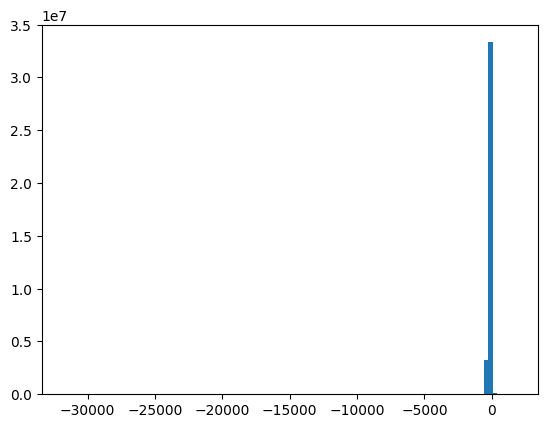

In [18]:
plt.hist(mean_image.flatten(),bins=100)

-- --

-- CREATING TILES FOR LOCAL BACKGROUND CALCULATION: NOT WELL


Total time: 0:00:00.025020


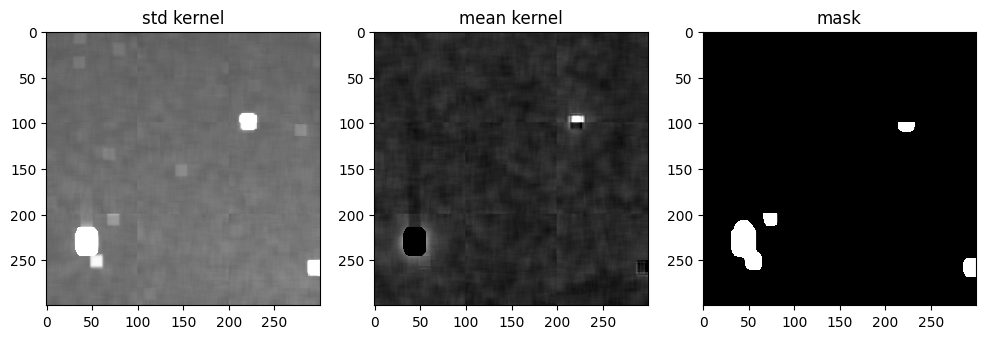

In [96]:
# Same thing but dividing the image in tiles to avoid memory issues and big background differences

def process_chunk(chunk):

    filter_size = int(5 * fwhm)
    if filter_size % 2 == 0:
        filter_size += 1

    mean_image = cv2.boxFilter(chunk, -1, (filter_size, filter_size))
    squared_img = cv2.boxFilter(chunk**2, -1, (filter_size, filter_size))
    std_dev_image = np.sqrt(squared_img - mean_image**2)

    sky_std_med = np.median(std_dev_image)
    mask_for_std = (std_dev_image < sky_std_med*1.5) & (std_dev_image > sky_std_med*0.5)
    sky_std_std = np.std(std_dev_image[mask_for_std])

    mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e4)

    sky_med = np.median(mean_image[~mask])
    sky_std = np.std(mean_image[~mask])
    mask = (mean_image < sky_med + 5*sky_std) & mask

    mask = (mask.astype(np.uint8) * 255) 
    mask_blurred = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3)
    mask = np.where(mask_blurred > 127, 255, 0).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel)

    return mean_image, std_dev_image, mask


def split_into_chunks(image, chunk_size):
    rows = image.shape[0] // chunk_size
    cols = image.shape[1] // chunk_size
    chunks = []
    for i in range(rows):
        for j in range(cols):
            chunk = image[i*chunk_size:(i+1)*chunk_size, j*chunk_size:(j+1)*chunk_size]
            chunks.append(chunk)
    return chunks

def stitch_chunks(chunks, image_shape, chunk_size):
    rows = image_shape[0] // chunk_size
    cols = image_shape[1] // chunk_size
    stitched_chunks = []
    for i in range(0, len(chunks), cols):
        stitched_row = np.hstack(chunks[i:i+cols])
        stitched_chunks.append(stitched_row)
    return np.vstack(stitched_chunks)




chunk_size = 100

t0 = datetime.now()

chunks = split_into_chunks(image, chunk_size)
results = [process_chunk(chunk) for chunk in chunks]
mean_chunks, std_dev_chunks, masks = zip(*results)
mean_image = stitch_chunks(mean_chunks, image.shape, chunk_size)
std_dev_image = stitch_chunks(std_dev_chunks, image.shape, chunk_size)
mask = stitch_chunks(masks, image.shape, chunk_size)



print('\nTotal time:', datetime.now() - t0)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(std_dev_image, cmap='gray', vmin=-10, vmax=40)
ax[0].set_title('std kernel')
ax[1].imshow(mean_image, cmap='gray', vmin=-10, vmax=40)
ax[1].set_title('mean kernel')
ax[2].imshow(mask, cmap='gray', vmin=0,vmax=1)
ax[2].set_title('mask')
plt.show()


Text(0.5, 1.0, 'Masked image')

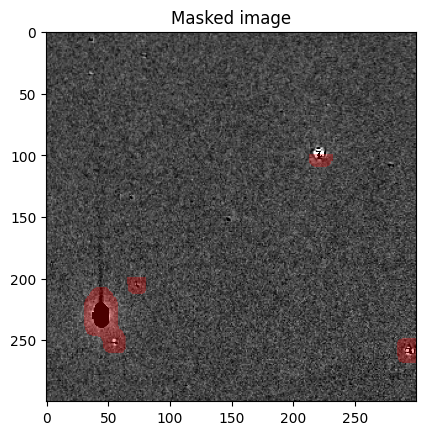

In [97]:
import matplotlib.colors as co
c_white = co.colorConverter.to_rgba('white',alpha = 0)
c_black= co.colorConverter.to_rgba('red',alpha = 0.6)
cmap_rb = co.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)
            
plt.imshow(image, cmap='gray', vmin=-40, vmax=100)
plt.imshow(mask, cmap=cmap_rb, alpha=0.5, vmin=0, vmax=1)
plt.title('Masked image')

-- --

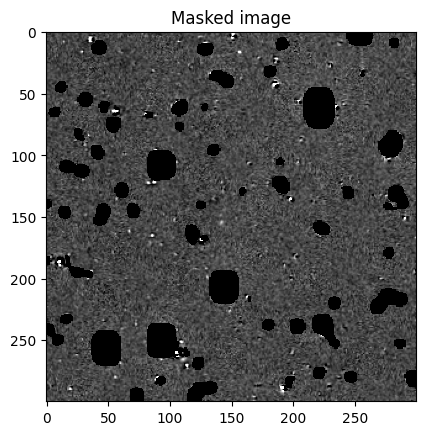

In [20]:
combined_image = image - (mask)*1e4

plt.imshow(combined_image, cmap='gray', vmin=-40, vmax=100)
plt.title('Masked image')
plt.show()

In [112]:
hdu = fits.PrimaryHDU(np.array([image, mask]).astype(np.int16))
hdu.writeto('residual_masking.fits', overwrite=True)

## Temporal std vs mean

In [67]:
per_pixel_std_image = np.std(img_array[:,::-1,::-1],axis=0)


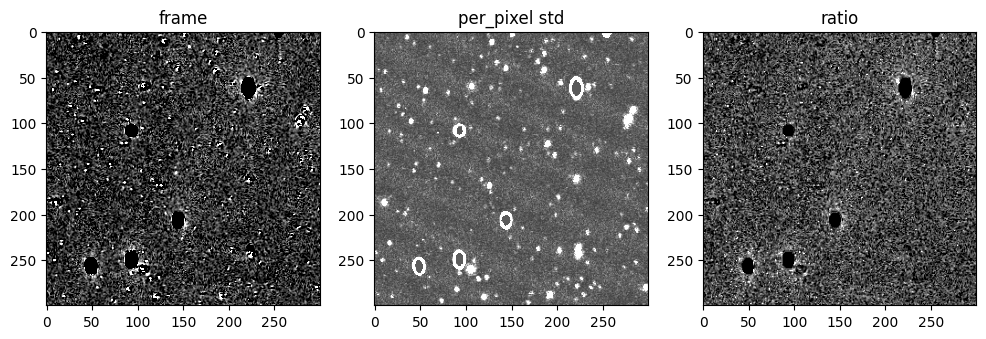

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(image, cmap='gray', vmin=-10, vmax=40)
ax[0].set_title('frame')
ax[1].imshow(per_pixel_std_image, cmap='gray', vmin=-10, vmax=40)
ax[1].set_title('per_pixel std')
ax[2].imshow(image / per_pixel_std_image, cmap='gray', vmin=-2,vmax=5)
ax[2].set_title('ratio')
plt.show()


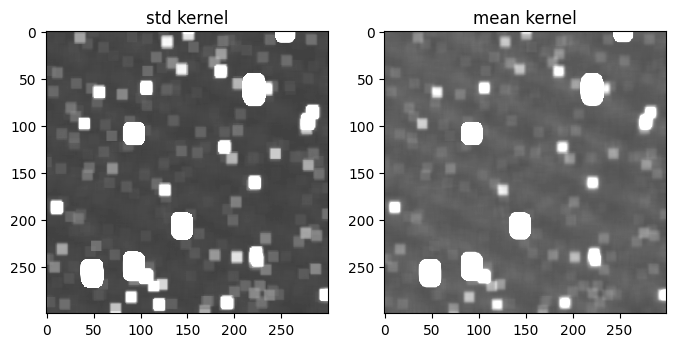

In [86]:
filter_size = int(5 * fwhm)
if filter_size % 2 == 0:
    filter_size += 1

mean_image = cv2.boxFilter(image, -1, (filter_size, filter_size))


mean_std_image = cv2.boxFilter(per_pixel_std_image, -1, (filter_size, filter_size))
squared_img = cv2.boxFilter(per_pixel_std_image**2, -1, (filter_size, filter_size))
std_dev_image = np.sqrt(squared_img - mean_std_image**2)



fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(std_dev_image, cmap='gray', vmin=-10, vmax=40)
ax[0].set_title('std kernel')
ax[1].imshow(mean_std_image, cmap='gray', vmin=-10, vmax=40)
ax[1].set_title('mean kernel')
plt.show()




mean_std_image_med = np.median(mean_std_image)
std_dev_image_med = np.median(std_dev_image)

mask_for_std = (std_dev_image < sky_std_med*1.25) & (std_dev_image > sky_std_med*0.75)
# sky_std_std = np.std(std_dev_image[mask_for_std])



# mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e3)

# sky_med = np.median(mean_image[~mask])
# sky_std = np.std(mean_image[~mask])


# mask = (mean_image < sky_med + sky_std) & mask

# time = datetime.now()
# mask = (mask.astype(np.uint8) * 255) 
# mask_blurred = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3)
# mask = np.where(mask_blurred > 127, 255, 0).astype(np.uint8)

In [82]:
mean_std_image_med = np.median(mean_std_image)
std_dev_image_med = np.median(std_dev_image)

In [84]:
mean_std_image_med, std_dev_image_med

(8.798885601956535, 3.8410086307165865)

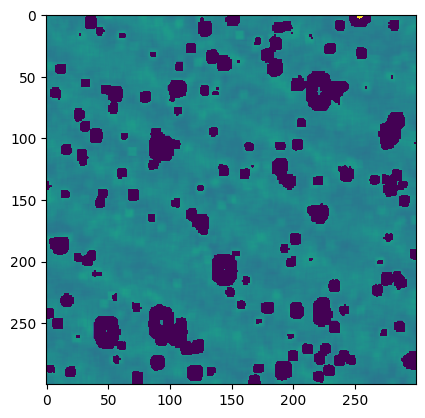

In [83]:
mask = (mean_std_image < mean_std_image_med-std_dev_image_med) | (mean_std_image > mean_std_image_med+std_dev_image_med)

masked = mean_std_image - 1e4*mask
plt.imshow(masked, vmin=-10,vmax=30)

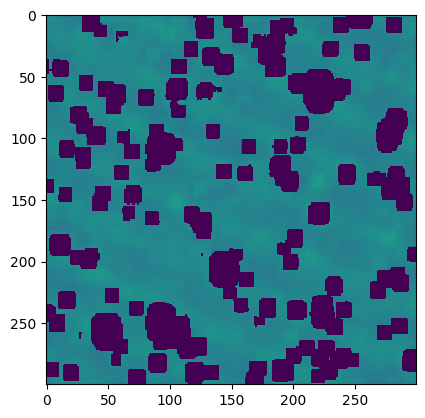

In [87]:
mean_std_image_med = np.median(mean_std_image)
std_dev_image_med = np.median(std_dev_image)

mask_for_std = (std_dev_image < std_dev_image_med*1.25) & (std_dev_image > std_dev_image_med*0.75)
sky_std_std = np.std(std_dev_image[mask_for_std])

mask = (std_dev_image > std_dev_image_med + 5*sky_std_std) #| (mean_image < -1e3)

# mask = (mean_std_image < mean_std_image_med-std_dev_image_med) | (mean_std_image > mean_std_image_med+std_dev_image_med)

masked = mean_std_image - 1e4*mask
plt.imshow(masked, vmin=-10,vmax=30)